# Models

<a id='contents'></a>
## Contents

* [Introduction](#introduction)
* [Choice of classifier and metric](#choice_classifier)
* [Data](#data)
* [Setup and loading data](#setup_and)
* [Filtering and train/test split](#filtering)
* [Creating an instance of the model class](#creating_an)
* [A first model (XGBoost)](#first_model)
* [Addressing class imbalance](#addressing)
* [Partial grid search](#partial_grid)
* [Final model](#final_model)
* [Saving/loading results](#savingloading)
* [Making predictions](#making_predictions)
* [Evaluation](#evaluation)
* [Other classifiers](#other_classifiers)

<a id='introduction'></a>
## Introduction
↑↑ [Contents](#contents) ↓ [Choice of classifier and metric](#choice_classifier)

We wish to use up to 17 categorical and three ordinal features of ~281,000 road collision records to classify them as either: 0 material damage only; 1 at least one minor injury; 2 at least one person seriously or fatally injured. See our [exploratory data analysis](./01-data-exploration-saaq.ipynb) for precise definitions and elucidation of the data. A key takeway from the EDA is that the dataset is highly imbalanced: less than 1% of accidents are in the most severe class, and less than 20% in the middling severity class. Another takeaway is that there are relationships among variables that are difficult to disentangle (we discussed the example of ```SPD_LIM```, ```ZONE```, ```MONTH```, and ```HOUR```).

<a id='choice_classifier'></a>
## Choice of classifier and metric
↑↑ [Contents](#contents) ↑ [Introduction](#introduction) ↓ [Data](#data)

**Classifier.** Considering the complexity of our classification problem, the imbalanced nature of our data, and the need for efficient handling of categorical variables and missing values, XGBoostClassifier stands out as a sound choice of classifier due to its robustness, speed, and theoretical underpinnings in gradient boosting techniques.

1. Handling Imbalanced Data: XGBoost is adept at handling imbalanced datasets, making it suitable for our situation in which severe accidents are rare compared to less severe ones. Its algorithm is designed to minimize loss while considering class imbalances, thus improving performance on minority classes.
2. Speed and Efficiency: XGBoost is known for its speed and efficiency, making it feasible to train on large datasets with numerous features. This is beneficial considering our dataset's size and the complexity of the classification task.
3. Handling Missing Values: XGBoost can handle missing values internally, reducing the preprocessing burden. Since our dataset contains missing values for most variables, this capability is advantageous and can lead to more robust models.
4. Feature Interaction Handling: While it's challenging to discern which variables might interact in our dataset, XGBoost's ensemble nature inherently captures interactions between features. This can lead to more nuanced and accurate predictions compared to simpler models.
5. Theoretical Basis for Gradient Boosting: Gradient boosting methods like XGBoost are theoretically sound and have been widely adopted in various domains due to their ability to iteratively improve model performance by focusing on the residuals of previous models. This iterative learning process can lead to strong predictive power even in complex, high-dimensional datasets like ours.

On the other hand, explainability and interpretability is very important when it comes to preventing severe traffic accidents. Interpreting XGBoost feature importance scores directly can be complex due to the ensemble nature of the model.

**Metric.** Correctly classifying the severity of an accident is plainly very important given that the goal is to help respond to, or reduce the frequency of, fatalities and serious injuries. Also, the more severe the accident, the more important it is to correctly classify it. For each class of accident, while class-wise precision and recall are both important, recall is the more important of the two. Therefore, class-wise $F_{\beta}$ score, for some $\beta > 1$, seems an appropriate metric to evaluate the performance of a model on each severity class. We choose $\beta = 2$.

To evaluate the overall performance of a model (across all classes), since the more severe an accident is, the smaller the class is, but the more important it is to "get it right", we will use a weighted average of the class-wise $F_2$ scores, with more weight going to the higher severity-level classes:

\begin{equation}
 F^{*}_{2} = \frac{\sum_{k = 0}^{n} w_kF^{(k)}_{2}}{\sum_{k = 0}^{n} w_k} 
\end{equation}

where $F^{(k)}_{2}$ denotes the $F_2$ score for severity class $k$, and $w_k$ denotes a weight associated with severity class $k$. We'll set $w_k = k + 1$ for $k = 0,\ldots,n$. Thus, in the case of our current ternary classification problem, 

\begin{equation}
F^{*}_{2} = \frac{1}{6}\left(F^{(0)}_{2} + 2F^{(1)}_{2} + 3F^{(2)}_{2}\right).\tag{$*$}
\end{equation}

<a id='data'></a>
## Data
↑↑ [Contents](#contents) ↑ [Choice of classifier and metric](#choice_classifier) ↓ [Setup and loading data](#setup_and)

SOCIÉTÉ DE L'ASSURANCE AUTOMOBILE DU QUÉBEC (SAAQ). Rapports d'accident, [Jeu de données], dans Données Québec, 2017, mis à jour le 18 decembre 2023. https://www.donneesquebec.ca/recherche/dataset/rapports-d-accident.

_Données issues des rapports d’accident remplis par les policiers, incluant notamment le moment, la gravité de l’accident de même que le type des véhicules impliqués._

QUEBEC AUTOMOBILE INSURANCE SOCIETY (SAAQ). Accident reports, [Dataset], in Data Quebec, 2017, updated December 18, 2023. https://www.donneesquebec.ca/recherche/dataset/rapports-d-accident, (accessed March 13, 2024).

_Data from accident reports completed by police officers, including the time, severity of the accident as well as the type of vehicles involved._

<a id='setup_and'></a>
## Setup and loading data
↑↑ [Contents](#contents) ↑ [Data](#data) ↓ [Filtering and train/test split](#filtering)

We repeat the setup, loading, and filtering and train/test split process of our [exploratory data analysis](./01-data-exploration-saaq.ipynb).

In [1]:
import os
from pathlib import Path
import sys

# If we're using Google Colab, we set the environment variable to point to the relevant folder in our Google Drive:
if 'COLAB_GPU' in os.environ:
    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['ROAD_SAFETY'] = '/content/drive/MyDrive/Colab Notebooks/road-safety'

# Otherwise, we use the environment variable on our local system:
project_environment_variable = "ROAD_SAFETY"

# Path to the root directory of the project:
project_path = Path(os.environ.get("ROAD_SAFETY"))

# Relative path to /scripts (from where custom modules will be imported):
scripts_path = project_path.joinpath("scripts")

# Add this path to sys.path so that Python will look there for modules:
sys.path.append(str(scripts_path))

# Now import path_step from our custom utils module to create a dictionary to all subdirectories in our root directory:
from utils import path_setup
path = path_setup.subfolders(base_path = project_path)


DICTIONARY 'PATH' CONTAINS PATHS TO SUBDIRECTORIES

path['project'] : F:\projects\road-safety
path['data'] : F:\projects\road-safety\data
path['expository'] : F:\projects\road-safety\expository
path['literature'] : F:\projects\road-safety\literature
path['notebooks'] : F:\projects\road-safety\notebooks
path['scripts'] : F:\projects\road-safety\scripts
path['models'] : F:\projects\road-safety\models
path['presentation'] : F:\projects\road-safety\presentation
path['streamlit'] : F:\projects\road-safety\streamlit


In [2]:
# Load csv files into one big dataframe
from processing import primary

data_dir: Path = path["data"]                 # Path to directory containing csv files
years: list = list(range(1999,2024))          # We want all data for years in this list, which does not have to be a subset of the years for which we actually hve data.
filename_format: str = "saaq_yyyy.csv"        # Or: "saaq_yyyy_fr.csv" (French version); "ncdb_yyyy.csv" (Canada-wide dataset).
Print: bool = False                           # If True, print value-count summary of dataframe.

saaq = primary(data_dir=data_dir,
               years=years,
               filename_format=filename_format,
               Print=Print,)


FOR EACH YEAR WE

  1. Read csv into dataframe.
  2. Replace strings 'x' by x if x is a number. May take a minute.
  3. Concatenate resulting dataframe with previous years' dataframe.

2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022 
SOURCE DATAFRAME: self.df


<a id='filtering'></a>
## Filtering and train/test split
↑↑ [Contents](#contents) ↑ [Setup and loading data](#setup_and) ↓ [Creating an instance of the model class](#creating_an)

In [3]:
from typing import Type, Union
import pandas as pd

source: Type[primary] = saaq                            # Source data.
restrict_to: Union[dict, None] = {"REGION" :            # Remove all records *unless* column k lies in list v, for k : v in restrict_to dictionary.
                                 ["Montréal (06)",],}    
    
remove_if: Union[dict,None] = None                      # Remove all records if column k lies in list v, for k : v in remove_if dictionary.    
drop_row_if_missing_value_in: Union[list, None] = None  # We drop all rows for which there is a missing value (i.e. sentinel value, if applicable) in a column from this list.   
                                                        # Should include targets in this list (no point having missing target values). 
                                                        # Also, any column in "stratify_by" below, otherwise the stratified train-test-split will throw an error (TypeError: '<' not supported between instances of 'float' and 'str') if the values are strings.
targets: list = ["TNRY_SEV"]                            # We intend to make predictions for values in each of these columns.
                                                        # Can add 'MULT_VEH', 'VICTIMS', and 'TNRY_SEV' to targets (saaq data): columns will be inserted automatically.
                                                        # Can add 'MULT_VEH', 'VICTIMS' to targets (ncdb data).
non_features: list = ["YEAR"]                           # Can add "ID" etc. here but "ID" and any target will automatically be removed from features 
features: list = [c for c in saaq.df.columns            # These are the features we will want to use to make predictions about the targets.
                    if c not in non_features]            
                  
test_size: float = 0.15                                 # We'll partition what's left of the rows into train/test sets, with this as relative test set size.
                                                        # We'll also split the 'train' set later, either through k-fold cross-validation or, if not, train will be split 90/10 with the 10% share going to validation.
seed: int = 0                                           # Wherever there is randomness (e.g. during train/test split we'll shuffle), we'll use this seed.
stratify: bool = True                                   # If True, we'll perform a stratified train/test split. Also applies to k-fold cross-validation (if applicable).
stratify_by: Union[list, None] = targets                # If stratify is True, we'll stratify train/test split so that proportions are maintained for tuples of values from columns in this list.

We will work with an instance of the ```process``` class, which we call ```mtl_3sev``` (Montreal, three-level severity).

In [4]:
from processing import process

mtl_3sev = process(source=source,
                   restrict_to=restrict_to,
                   remove_if=remove_if,
                   drop_row_if_missing_value_in=drop_row_if_missing_value_in,
                   targets=targets,
                   features=features,
                   test_size=test_size,
                   seed=seed,
                   stratify=stratify,
                   stratify_by=stratify_by)

Removing ID from self.features

Removing all records unless:
  REGION in ['Montréal (06)']

Inserting 'TNRY_SEV' column.

Removing REGION from self.features (but not from self.df) as the number of distinct non-null values in self.df['REGION'] is 1.

Removing SEVERITY from self.features (but not from self.df): can't use SEVERITY to predict TNRY_SEV.

Removing NUM_VICTIMS from self.features (but not from self.df): can't use NUM_VICTIMS to predict TNRY_SEV.

Partitioning data into training/test sets: self.df_train/self.df_test.

self.ordinal_features = ['SPD_LIM', 'LIGHT', 'NUM_VEH']

self.ordinal_targets = ['TNRY_SEV']

self.categorical_features = ['ACCDN_TYPE', 'LT_TRK', 'BICYC', 'PED', 'HVY_VEH', 'RD_CONFG', 'PUB_PRIV_RD', 'LONG_LOC', 'MONTH', 'RDWX', 'MTRCYC', 'WKDY_WKND', 'ASPECT', 'HOUR', 'RD_COND', 'ZONE', 'WEATHER']

self.categorical_targets = []


<a id='creating_an'></a>
## Creating an instance of the model class
↑↑ [Contents](#contents) ↑ [Filtering and train/test split](#filtering) ↓ [A first model (XGBoost)](#first_model)

In our custom ```models``` module we have created a class called ```model```, attributes of which include ```data``` (an instance of the ```process``` class), ```classifier```, which can be any of five different kinds of classifier, ```folds```, which will be the $k$ in $k$-fold cross-validation, and so on. The attribute ```balance``` is set to ```None``` initially, but later will cap the number of times a record from a minority class can be upsampled during training.

In [17]:
from models import model
from typing import Optional, Type, Union, Callable
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

data: Type[process] = mtl_3sev    
folds: Union[int, None] = 5 
impute_strategy: Union[dict, None] = None #{'categorical': 'most_frequent', 'ordinal': 'most_frequent', 'constant' : -1}
classifier: Union[DecisionTreeClassifier,
                  GradientBoostingClassifier,
                  LogisticRegression, 
                  RandomForestClassifier, 
                  XGBClassifier,] = XGBClassifier(objective='multi:softmax', # 'binary:logistic', if two classes
                                                  eval_metric='mlogloss', # 'logloss', if two classes
                                                  max_delta_step=1,                                                   
                                                  importance_type='weight', 
                                                  max_depth = 6, 
                                                  n_estimators = 100, 
                                                  nthread=-1,)
balance: Union[int, None] = None
filename_stem: str = "mtl_3sev"
model_dir: Path = path["models"]    

<a id='first_model'></a>
## A first model (XGBoost)
↑↑ [Contents](#contents) ↑ [Creating an instance of the model class](#creating_an) ↓ [Addressing class imbalance](#addressing)

We can pass these attributes to the ```model``` class to create an instance, which we name ```mtl_3sev_xgb```. The printed output will explain what is happening.


SEPARATING FEATURES FROM TARGETS

self.X_train/self.X_test, self.y_train/self.y_test

MAPPING ORDINAL FEATURE/TARGET CODES

SPD_LIM: {'<50': 0, 50: 5, 60: 6, 70: 7, 80: 8, 90: 9, 100: 10}
LIGHT: {1: 3, 2: 2, 3: 1, 4: 0}
NUM_VEH: {1: 0, 2: 1, 9: 2}
TNRY_SEV: {0: 0, 1: 1, 2: 2}

MAPPING CATEGORICAL FEATURE/TARGET CODES

ACCDN_TYPE: {'vehicle': 0, 'pedestrian': 1, 'cyclist': 2, 'animal': 3, 'fixed object': 4, 'no collision': 5, 'other': 6}
LT_TRK: {'N': 0, 'Y': 1}
BICYC: {'N': 0, 'Y': 1}
PED: {'N': 0, 'Y': 1}
HVY_VEH: {'N': 0, 'Y': 1}
RD_CONFG: {1: 0, 23: 1, 45: 2, 9: 3}
PUB_PRIV_RD: {1: 0, 2: 1}
LONG_LOC: {12: 0, 33: 1, 34: 2, 40: 3, 69: 4, 99: 5}
MONTH: {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12}
RDWX: {'N': 0, 'Y': 1}
MTRCYC: {'N': 0, 'Y': 1}
WKDY_WKND: {'WKDY': 0, 'WKND': 1}
ASPECT: {'Straight': 0, 'Curve': 1}
HOUR: {'00:00:00-03:59:00': 0, '04:00:00-07:59:00': 1, '08:00:00-11:59:00': 2, '12:00:00-15:59:00': 3, '16:00:00-19:59:00': 4, '20:00:00-23:5

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[[0,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9,
                                                                              10],
                                                                             [0,
                                                                              1,
                                                                              2,
                                                                              3],
                                                                             [0,
                                                                              1,
                                                                              2]],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['SPD_LIM', 'LIGHT',
                                                   'NUM_VEH']),
                                                 ('onehot',
                                                  OneHotEncoder(categories=[[0,
                                                                             1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1,
                                                                             2,
                                                                             3],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1,
                                                                             2,
                                                                             3,
                                                                             4,...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type='weight',
                               interaction_constraints=None, learning_rate=None,
                 


       MAKING PREDICTIONS ON VALIDATION FOLD

CV 1:  FOLDING FITTING

       MAKING PREDICTIONS ON VALIDATION FOLD

CV 2:  FOLDING FITTING

       MAKING PREDICTIONS ON VALIDATION FOLD

CV 3:  FOLDING FITTING

       MAKING PREDICTIONS ON VALIDATION FOLD

CV 4:  FOLDING FITTING

       MAKING PREDICTIONS ON VALIDATION FOLD

Target, prediction, and probabilities for each validation fold stored in self.preds dictionary.

Feature importances corresponding to each validation fold stored in self.feature_importances dictionary.

SAVING PIPELINE

F:\projects\road-safety\models\mtl_3sev_xgb.joblib

Metrics (including confusion matrices) contained in dictionary self.eval
Metrics (excluding confusion matrices) also contained in dataframe self.eval_df

EVALUATION METRICS FOR EACH FOLD



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.854974,0.451425,0.703610,0.451425,0.478009,0.457873,0.482084,0.843820
1,0.854279,0.451579,0.658248,0.451579,0.479657,0.458345,0.478932,0.844434
2,0.855953,0.453239,0.634036,0.453239,0.480596,0.459941,0.486516,0.845408
3,0.855401,0.448354,0.605800,0.448354,0.473124,0.454243,0.483662,0.843803
4,0.855487,0.450496,0.620162,0.450496,0.476467,0.456761,0.484229,0.840916
mean,0.855219,0.451019,0.644371,0.451019,0.477570,0.457433,0.483085,0.843676


0

predicted,0,1,2,All,recall
actual,,,,,
0,"44,114",709,2,"44,825",0.984138
1,"6,953","3,910",4,"10,867",0.359805
2,183,296,5,484,0.010331
All,"51,250","4,915",11,"56,176",_
precision,0.860761,0.795524,0.454545,_,0.300561


1

predicted,0,1,2,All,recall
actual,,,,,
0,"44,141",681,4,"44,826",0.984719
1,"7,012","3,841",13,"10,866",0.353488
2,164,312,8,484,0.016529
All,"51,317","4,834",25,"56,176",_
precision,0.860163,0.79458,0.32,_,0.302245


2

predicted,0,1,2,All,recall
actual,,,,,
0,"44,137",687,2,"44,826",0.984629
1,"6,908","3,941",17,"10,866",0.362691
2,183,295,6,484,0.012397
All,"51,228","4,923",25,"56,176",_
precision,0.86158,0.800528,0.24,_,0.302943


3

predicted,0,1,2,All,recall
actual,,,,,
0,"44,193",633,0,"44,826",0.985879
1,"6,997","3,858",11,"10,866",0.355052
2,169,313,2,484,0.004132
All,"51,359","4,804",13,"56,176",_
precision,0.860472,0.803081,0.153846,_,0.295439


4

predicted,0,1,2,All,recall
actual,,,,,
0,"44,163",662,1,"44,826",0.985209
1,"6,961","3,890",15,"10,866",0.357997
2,165,314,4,483,0.008282
All,"51,289","4,866",20,"56,175",_
precision,0.861062,0.799425,0.2,_,0.29887



Feature importances corresponding to validation set(s) contained in self.feature_importances and self.feature_importances_df.


FEATURE IMPORTANCE



,0,1,2,3,4
MONTH,0.268434,0.268276,0.269979,0.272612,0.269558
RD_COND,0.108734,0.112378,0.114495,0.108227,0.110835
ACCDN_TYPE,0.090319,0.094716,0.089382,0.093871,0.092764
WEATHER,0.087797,0.087860,0.081902,0.084722,0.089150
LONG_LOC,0.086116,0.084134,0.088467,0.093796,0.088849
ZONE,0.066096,0.069603,0.066254,0.066349,0.064378
HOUR,0.053259,0.051569,0.055797,0.049539,0.052255
WKDY_WKND,0.040575,0.043222,0.042363,0.043365,0.040810
ASPECT,0.031023,0.031299,0.029082,0.029902,0.029215
LT_TRK,0.027432,0.026902,0.027784,0.028637,0.028311


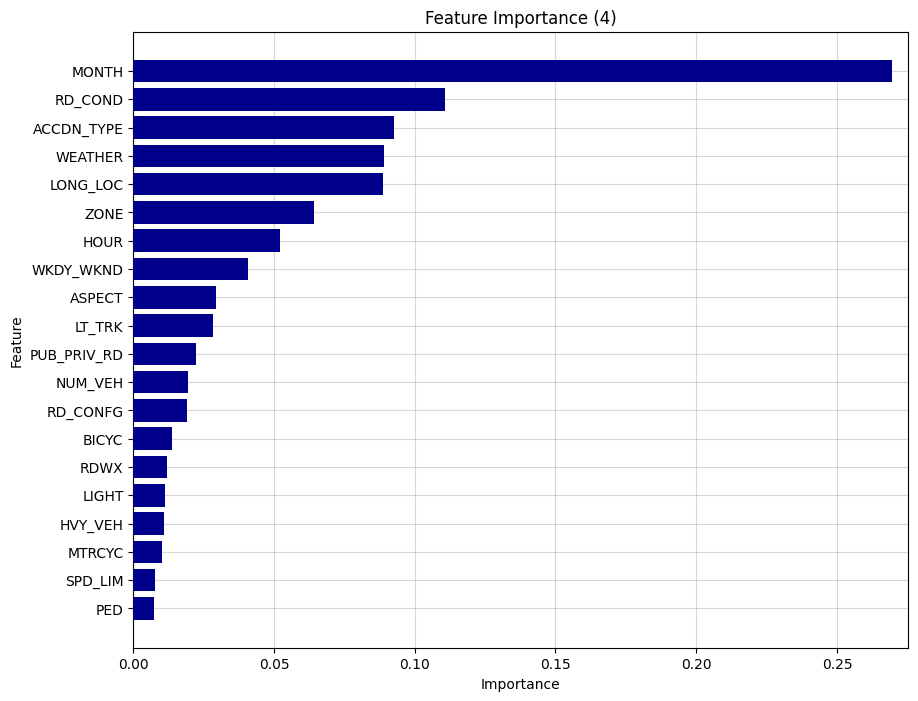

In [18]:
mtl_3sev_xgb = model(data=data,    
                     folds=folds, 
                     impute_strategy=impute_strategy, 
                     classifier=classifier,
                     balance=balance,
                     filename_stem=filename_stem,
                     model_dir=model_dir,)

As can be seen from the confusion matrix, the model correctly classifies around 4 out of the 484 most severe accidents represented in the validation folds. The weighted average class-wise $F_2$ score (which we call $F_2^*$, see [($*$)](#choice_classifier)) is shown in the bottom right corner of the matrix. We will improve our model's performance with respect to $F_2^*$ by focusing on the recall for the highest severity-level class (see [below](#addressing)).

Although $F_2^*$ is the one metric we will use to evaluate our model, our ```model``` class also outputs global metrics, including accuracy ```ACC```, balanced accuracy ```BACC```, precision, recall, $F_1$, $F_2$, Matthews Correlation Coefficient ```MCC```, and One-vs-Rest (OvR) Receiver Operating Characteristic - Area Under the Curve ```ROC-AUC```. The global precision, recall, and $F$-scores use macro-averaging and so give equal weight to each severity class, which is not what we want.

Before moving on to address the class imbalance, for what it's worth we can compare our first model to a trivial model that labels all accidents as level zero severity (the majority class). This model obviously has high precision and recall with respect to the majority class, but is otiose with respect to the other classes, which are more important to us.

In [17]:
import numpy as np
from utils import print_header
from models import display_confusion_matrices, confusion_matrix_with_weighted_fbeta

instance = mtl_3sev_xgb

print_header("Metrics for *trivial prediction* (all labels majority class)")
display(instance.triv_eval_df.loc[[0]])

print_header("Confusion matrix for *trivial prediction* (all labels majority class)")

t = instance.triv_eval["confusion"][0]
for i in instance.class_codes[instance.data.targets[0]].values():
    if i not in t.keys():
        t[i] = 0
t = pd.DataFrame(t)        
column_order = list(range(t.shape[1]))  # Get the current column order
column_order.remove(t.columns.get_loc('All'))  # Remove the index of 'All' from the list
column_order.append(t.columns.get_loc('All'))  # Append the index of 'All' to the end of the list
t = t.iloc[:, column_order] 
display(confusion_matrix_with_weighted_fbeta(t, beta = instance.beta, weights = instance.weights).fillna('_'))


METRICS FOR *TRIVIAL PREDICTION* (ALL LABELS MAJORITY CLASS)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.797939,0.333333,0.797939,0.333333,0.295872,0.317265,0.0,0.5



CONFUSION MATRIX FOR *TRIVIAL PREDICTION* (ALL LABELS MAJORITY CLASS)



predicted,0,1,2,All,recall
actual,,,,,
0,"44,825",0,0,"44,825",1.0
1,"10,867",0,0,"10,867",0.0
2,484,0,0,484,0.0
All,"56,176",0,0,"56,176",_
precision,0.797939,_,_,_,_


In [47]:
del t

In [49]:
print_header("Metrics for *trivial prediction* (all labels minority class)")
display(instance.triv_min_eval_df.loc[[0]])

print_header("Confusion matrix for *trivial prediction* (all labels minority class)")

t = instance.triv_min_eval["confusion"][0]

for i in instance.class_codes[instance.data.targets[0]].values():
    if i not in t.keys():
        t[i] = 0
       
t = pd.DataFrame(t)  
t = t[[0,1,2,'All']]
display(confusion_matrix_with_weighted_fbeta(t, beta = instance.beta, weights = instance.weights).fillna('_'))


METRICS FOR *TRIVIAL PREDICTION* (ALL LABELS MINORITY CLASS)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.008616,0.333333,0.008616,0.333333,0.005695,0.013881,0.0,0.5



CONFUSION MATRIX FOR *TRIVIAL PREDICTION* (ALL LABELS MINORITY CLASS)



predicted,0,1,2,All,recall
actual,,,,,
0,0,0,"44,825","44,825",0.0
1,0,0,"10,867","10,867",0.0
2,0,0,484,484,1.0
All,0,0,"56,176","56,176",_
precision,_,_,0.008616,_,_


<a id='addressing'></a>
## Addressing class imbalance
↑↑ [Contents](#contents) ↑ [A first model (XGBoost)](#first_model) ↓ [Partial grid search](#partial_grid)

We clearly must do better in terms of recall for the level 2 and (especially) level 3 severity classes. As can be seen below, the training set contains 92 times as many level 0 severity accidents as level 3 severity. We're going 5-fold cross-validation: below is a code snippet from the ```fit``` method of our ```models``` class, which shows how ```X_train``` and ```y_train``` are folded, before the model is fit to the updated ```X_train``` and ```y_train```.

```
X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
```

```self.pipeline.fit(X_train, np.ravel(y_train))```

Our ```balance``` function replaces ```X_train``` and ```y_train``` by ```X_balance``` and ```y_balance``` immediately prior to fitting. The balanced data upsamples the minority classes by a factor specified by the ```balance``` attribute of our ```models``` class.

We experiment with different choices of the ```balance``` parameter: essentially, the more we upsample, the better the recall for the level 2 severity class, but it comes at the expense of the recall for the level 0 severity class. We accept this, since for our purposes, misclassifying a more severe accident is worse than misclassifying a less severe one. We can go from correctly classifying about 4 out of 484 level 3 severity accidents in the validation folds, to correctly classifying around 300 of them. However, in terms of our metric $F_2^*$ (weighted average class-wise $F_2$ score, see [($*$)](#choice_classifier)), it turns out that the the optimal maximum number of samples we should use is around 40 (in which case, the model correctly classifies around 150 of the 484 most severe accidents).  

This is a substantial improvement, but it does not go as far as we would like. We can do an ad hoc, 'partial grid search' by experimenting with ```max_depth``` and ```n_estimators``` parameters of ```XGBClassifier```, but this does not have much of an effect. We do not believe that any choice of parameters will lead to much better performance than what we see below.

In [8]:
instance = mtl_3sev_xgb
print(instance.y_train["TNRY_SEV"].value_counts())
print(instance.y_train["TNRY_SEV"].value_counts()[0]//instance.y_train["TNRY_SEV"].value_counts()[2])

0    224129
1     54331
2      2419
Name: TNRY_SEV, dtype: int64
92


<a id='partial_grid'></a>
## Partial grid search
↑↑ [Contents](#contents) ↑ [Addressing class imbalance](#addressing) ↓ [Final model](#final_model)

In the code cell below, we call instances of our ```model``` class with various combinations of the attribute ```balance```, and the parameters ```max_depth``` and ```n_estimators``` of the ```XGBClassifier``` (which is passed to the ```classifier``` attribute of our ```model``` class). 

The ```save_gs_items``` function saves the global metrics and confusion matrices (stored in a dictionary) to a ```.txt``` file, while ```load_gs_items``` does the reverse. If we find a ```(balance, max_depth, n_estimators)``` key in the ```.txt``` file, there is no need to run the model again so we pass to the next combination.

In [63]:
from utils import clear_output, print_header
from models import save_gs_items, load_gs_items, custom_xgb_grid_search

filename = 'mtl_3sev_gs'
try:
    mtl_3sev_gs = load_gs_items(model_dir=model_dir, filename=filename)
except:
    mtl_3sev_gs = {}

max_depth = 3
n_estimators = 100
for balance in [1] + [10*i for i in range(1,10)]:
    for max_depth in [3,6]:
        for n_estimators in [100,150]:
            key = str((balance, max_depth, n_estimators))
            if key in mtl_3sev_gs.keys():
                pass
            else:
                print_header(f"(balance, max_depth, n_estimators) = ({balance}, {max_depth}, {n_estimators})")
                mtl_3sev_gs[key] = custom_xgb_grid_search(data=data,    
                                                                 folds=folds, 
                                                                 impute_strategy=impute_strategy, 
                                                                 balance=balance,
                                                                 filename_stem="xgb_gs",
                                                                 model_dir=model_dir,    
                                                                 max_depth=max_depth, 
                                                                 n_estimators=n_estimators,)
                clear_output()

save_gs_items(model_dir=model_dir,
              filename=filename,
              gs_dict=mtl_3sev_gs)

We can load the results here and examine them. As mentioned earlier, the global metrics should be taken with a grain of salt: our metric is the $F_2^*$ score (weighted average of class-wise $F_2$ scores, as in [($*$)](#choice_classifier)). 

In [4]:
from models import load_gs_items, evaluation_df, confusion_matrix_widget, confusion_matrix_with_weighted_fbeta
import numpy as np

filename = 'mtl_3sev_gs'
gs_dict = load_gs_items(model_dir=model_dir, filename=filename)

beta = 2
weights = np.array([1,2,3])

best = 0
arg_best = ''
best_recall_2 = 0
arg_best_recall_2 = ''

for gs_parameters in gs_dict.keys():
#     print_header(f"(balance, max_depth, n_estimators) = {gs_parameters}")
#     metrics = { k : v for k, v in gs_dict[gs_parameters]["evaluation"].items() if k != "confusion"}
#     display(evaluation_df(metrics).loc[['mean']])
#     confusion_matrix_widget(gs_dict[gs_parameters]['evaluation'],
#                             confusion_matrix_with_weighted_fbeta,
#                             beta = beta,
#                             weights = weights)
    for i, cm in enumerate(gs_dict[gs_parameters]['evaluation']['confusion']):
        cm = confusion_matrix_with_weighted_fbeta(cm,
                            beta = beta,
                            weights = weights)
        if best < cm.iloc[-1,-1]:
            best = cm.iloc[-1,-1]
            arg_best = gs_parameters
        if best_recall_2 < cm.iloc[-3,-1]:
            best_recall_2 = cm.iloc[-3,-1]
            arg_best_recall_2 = gs_parameters

In [6]:
from utils import print_header

print_header(f"(balance, max_depth, n_estimators) = {arg_best}")
metrics = { k : v for k, v in gs_dict[arg_best]["evaluation"].items() if k != "confusion"}
display(evaluation_df(metrics).loc[['mean']])
confusion_matrix_widget(gs_dict[arg_best]['evaluation'],
                        confusion_matrix_with_weighted_fbeta,
                        beta = beta,
                        weights = weights)
for i, cm in enumerate(gs_dict[arg_best]['evaluation']['confusion']):
    cm = confusion_matrix_with_weighted_fbeta(cm,
                        beta = beta,
                        weights = weights)


(BALANCE, MAX_DEPTH, N_ESTIMATORS) = (40, 3, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
mean,0.74013,0.574942,0.475149,0.574942,0.495609,0.530024,0.382265,0.832213



CONFUSION MATRIX: WEIGHTED ({0: 1, 1: 2, 2: 3}) AVERAGE CLASS-WISE F2 SCORE AT BOTTOM RIGHT



Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()

In [7]:
print_header(f"(balance, max_depth, n_estimators) = {arg_best_recall_2}")
metrics = { k : v for k, v in gs_dict[arg_best_recall_2]["evaluation"].items() if k != "confusion"}
display(evaluation_df(metrics).loc[['mean']])
confusion_matrix_widget(gs_dict[arg_best_recall_2]['evaluation'],
                        confusion_matrix_with_weighted_fbeta,
                        beta = beta,
                        weights = weights)
for i, cm in enumerate(gs_dict[arg_best_recall_2]['evaluation']['confusion']):
    cm = confusion_matrix_with_weighted_fbeta(cm,
                        beta = beta,
                        weights = weights)


(BALANCE, MAX_DEPTH, N_ESTIMATORS) = (90, 3, 100)



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
mean,0.692697,0.615904,0.442657,0.615904,0.441762,0.471213,0.305195,0.819645



CONFUSION MATRIX: WEIGHTED ({0: 1, 1: 2, 2: 3}) AVERAGE CLASS-WISE F2 SCORE AT BOTTOM RIGHT



Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()

<a id='final_model'></a>
## Final model
↑↑ [Contents](#contents) ↑ [Partial grid search](#partial_grid) ↓ [Saving/loading results](#savingloading)

It is a matter of judgement, but we opt to choose maximal ```balance``` parameter (we'll go with 95), ```max_depth``` 3 and ```n_estimators``` 100.

In [64]:
data: Type[process] = mtl_3sev    
folds: Union[int, None] = 5 
impute_strategy: Union[dict, None] = None #{'categorical': 'most_frequent', 'ordinal': 'most_frequent', 'constant' : -1}
classifier: Union[DecisionTreeClassifier,
                  GradientBoostingClassifier,
                  LogisticRegression, 
                  RandomForestClassifier, 
                  XGBClassifier,] = XGBClassifier(objective='multi:softmax', # 'binary:logistic', if two classes
                                                  eval_metric='mlogloss', # 'logloss', if two classes
                                                  max_delta_step=1,                                                   
                                                  importance_type='weight', 
                                                  max_depth = 3, 
                                                  n_estimators = 100, 
                                                  nthread=-1,)
balance: Union[int, None] = 40
filename_stem: str = "mtl_3sev"
model_dir: Path = path["models"]   


SEPARATING FEATURES FROM TARGETS

self.X_train/self.X_test, self.y_train/self.y_test

MAPPING ORDINAL FEATURE/TARGET CODES

SPD_LIM: {'<50': 0, 50: 5, 60: 6, 70: 7, 80: 8, 90: 9, 100: 10}
LIGHT: {1: 3, 2: 2, 3: 1, 4: 0}
NUM_VEH: {1: 0, 2: 1, 9: 2}
TNRY_SEV: {0: 0, 1: 1, 2: 2}

MAPPING CATEGORICAL FEATURE/TARGET CODES

LT_TRK: {'N': 0, 'Y': 1}
WKDY_WKND: {'WKDY': 0, 'WKND': 1}
ACCDN_TYPE: {'vehicle': 0, 'pedestrian': 1, 'cyclist': 2, 'animal': 3, 'fixed object': 4, 'no collision': 5, 'other': 6}
MONTH: {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12}
LONG_LOC: {12: 0, 33: 1, 34: 2, 40: 3, 69: 4, 99: 5}
HVY_VEH: {'N': 0, 'Y': 1}
ZONE: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 9: 6}
WEATHER: {11: 0, 12: 1, 13: 2, 14: 3, 15: 4, 16: 5, 17: 6, 18: 7, 19: 8, 99: 9}
RD_COND: {11: 0, 12: 1, 13: 2, 14: 3, 15: 4, 16: 5, 17: 6, 18: 7, 19: 8, 20: 9, 99: 10}
BICYC: {'N': 0, 'Y': 1}
ASPECT: {'Straight': 0, 'Curve': 1}
RDWX: {'N': 0, 'Y': 1}
RD_CONFG: {1: 0, 23: 1, 45: 2, 9: 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[[0,
                                                                              5,
                                                                              6,
                                                                              7,
                                                                              8,
                                                                              9,
                                                                              10],
                                                                             [0,
                                                                              1,
                                                                              2,
                                                                              3],
                                                                             [0,
                                                                              1,
                                                                              2]],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=nan),
                                                  ['SPD_LIM', 'LIGHT',
                                                   'NUM_VEH']),
                                                 ('onehot',
                                                  OneHotEncoder(categories=[[0,
                                                                             1],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6],
                                                                            [1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12],
                                                                            [0,
                                                                             1,
                                                                             2,
                                                                             3,
                                                                             4...
                               feature_types=None, gamma=None, grow_policy=No


       MAKING PREDICTIONS ON VALIDATION FOLD

CV 1:  FOLDING BALANCING FITTING

       MAKING PREDICTIONS ON VALIDATION FOLD

CV 2:  FOLDING BALANCING FITTING

       MAKING PREDICTIONS ON VALIDATION FOLD

CV 3:  FOLDING BALANCING FITTING

       MAKING PREDICTIONS ON VALIDATION FOLD

CV 4:  FOLDING BALANCING FITTING

       MAKING PREDICTIONS ON VALIDATION FOLD

Target, prediction, and probabilities for each validation fold stored in self.preds dictionary.

Feature importances corresponding to each validation fold stored in self.feature_importances dictionary.

SAVING PIPELINE

D:\projects\road-safety\models\mtl_3sev_xgb.joblib

Metrics (including confusion matrices) contained in dictionary self.eval
Metrics (excluding confusion matrices) also contained in dataframe self.eval_df

EVALUATION METRICS FOR EACH FOLD



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.740174,0.572677,0.474135,0.572677,0.494315,0.528226,0.380671,0.831715
1,0.740334,0.572179,0.474866,0.572179,0.494871,0.528626,0.383960,0.832293
2,0.737432,0.575518,0.473333,0.575518,0.493349,0.528392,0.379123,0.833668
3,0.742381,0.568040,0.474103,0.568040,0.493665,0.526197,0.384767,0.833003
4,0.740329,0.586298,0.479310,0.586298,0.501843,0.538676,0.382805,0.830384
mean,0.740130,0.574942,0.475149,0.574942,0.495609,0.530024,0.382265,0.832213



CONFUSION MATRIX: WEIGHTED ({0: 1, 1: 2, 2: 3}) AVERAGE CLASS-WISE F2 SCORE AT BOTTOM RIGHT



Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Feature importances corresponding to validation set(s) contained in self.feature_importances and self.feature_importances_df.


FEATURE IMPORTANCE



interactive(children=(Dropdown(description='Sort by:', options=(0, 1, 2, 3, 4), value=0), Output()), _dom_clas…

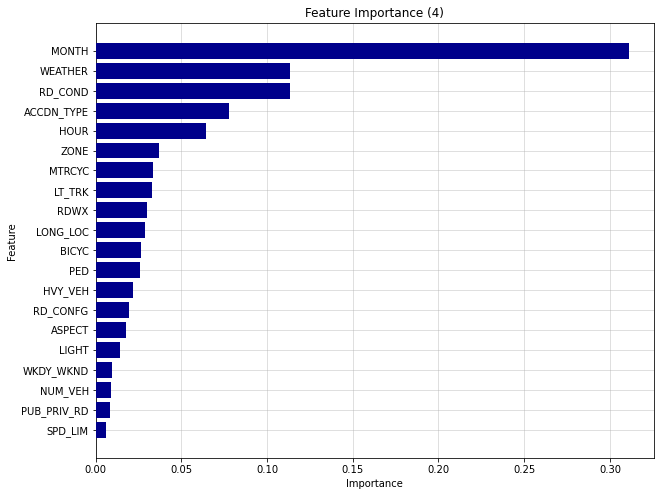

In [65]:
mtl_3sev_xgb = model(data=data,    
                     folds=folds, 
                     impute_strategy=impute_strategy, 
                     classifier=classifier,
                     balance=balance,
                     filename_stem=filename_stem,
                     model_dir=model_dir,)

<a id='savingloading'></a>
## Saving/loading results
↑↑ [Contents](#contents) ↑ [Final model](#final_model) ↓ [Making predictions](#making_predictions)

In [70]:
# Let's save the results so that we don't have to re-run the model to see them
# Convert the dataframes to dictionaries for storage in text file...

import copy

instance = mtl_3sev_xgb

output = {'final': {} }
output['final']['evaluation'] = copy.deepcopy(instance.eval)
output['final']['feature_importance'] = instance.feature_importances

# Now we can use our save_gs_items function...

save_gs_items(model_dir=path["models"],
              filename='mtl_3sev_xgb_final',
              gs_dict=output)    

In [34]:
# And we can load and display the results again here...

filename = 'mtl_3sev_xgb_final'
final_dict = load_gs_items(model_dir=model_dir, filename=filename)

beta = 2
weights = np.array([1,2,3])

metrics = { k : v for k, v in final_dict['final']["evaluation"].items() if k != "confusion"}
display(evaluation_df(metrics))
confusion_matrix_widget(final_dict['final']['evaluation'],
                        confusion_matrix_with_weighted_fbeta,
                        beta = beta,
                        weights = weights)
for i, cm in enumerate(final_dict['final']['evaluation']['confusion']):
    cm = confusion_matrix_with_weighted_fbeta(cm,
                        beta = beta,
                        weights = weights)

,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.740174,0.572677,0.474135,0.572677,0.494315,0.528226,0.380671,0.831715
1,0.740334,0.572179,0.474866,0.572179,0.494871,0.528626,0.383960,0.832293
2,0.737432,0.575518,0.473333,0.575518,0.493349,0.528392,0.379123,0.833668
3,0.742381,0.568040,0.474103,0.568040,0.493665,0.526197,0.384767,0.833003
4,0.740329,0.586298,0.479310,0.586298,0.501843,0.538676,0.382805,0.830384
mean,0.740130,0.574942,0.475149,0.574942,0.495609,0.530024,0.382265,0.832213



CONFUSION MATRIX: WEIGHTED ({0: 1, 1: 2, 2: 3}) AVERAGE CLASS-WISE F2 SCORE AT BOTTOM RIGHT



Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()

In [50]:
# Let's not forget the feature importances...

from models import df_display_widget, display_sorted_dataframe

df_display_widget(pd.DataFrame(final_dict['final']['feature_importance']))

interactive(children=(Dropdown(description='Sort by:', options=(0, 1, 2, 3, 4), value=0), Output()), _dom_clas…

<a id='making_predictions'></a>
## Making predictions
↑↑ [Contents](#contents) ↑ [Saving/loading results](#savingloading) ↓ [Evaluation](#evaluation)

Now let's use our model to make predictions on data it hasn't seen before.

In [51]:
import joblib
import random
import pandas as pd

instance = mtl_3sev_xgb
trained = joblib.load(instance.filepath)
 
new_data = dict.fromkeys(instance.data.features)
for feature in new_data.keys():
    new_data[feature] = random.choice(list(instance.class_codes[feature].values()))

new_data_df = pd.DataFrame(new_data, columns = instance.data.features, index=[0])

predictions = trained.predict(new_data_df)
probabilities = trained.predict_proba(new_data_df)

print(f"prediction: {predictions[0]}", f"\nprobabilities: {probabilities[0]}")

prediction: 0 
probabilities: [0.55395454 0.27356073 0.17248467]


<a id='evaluation'></a>
## Evaluation
↑↑ [Contents](#contents) ↑ [Making predictions](#making_predictions) ↓ [Other classifiers](#other_classifiers)

Now for the moment of truth. We evaluate our model on the test data that has been 'locked in the vault' until now. We've applied the same mappings to the test data as we did to the training data, but we've done nothing else with it. We see similar results in the confusion matrices below as we did in the confusion matrices in our cross-validation process.

We might have hoped for better results, but we may be close to the limit of what can be done with the data. Perhaps there are other features of road accidents that can be reported, that may enable better predictions.

In [52]:
import numpy as np
instance = mtl_3sev_xgb
test = {0: {} }
test[0]["target"] = np.ravel(instance.y_test)
test[0]["prediction"] = trained.predict(instance.X_test)
test[0]["probabilities"] = trained.predict_proba(instance.X_test)

In [67]:
from models import display_confusion_matrices

test_eval = instance.evaluate(test)
display(evaluation_df(test_eval))

beta = 2
weights = np.array([1,2,3])

display_confusion_matrices(test_eval,
                          confusion_matrix_with_weighted_fbeta,
                          beta = beta,
                          weights = weights)

,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.738879,0.570093,0.47332,0.570093,0.493219,0.526718,0.378593,0.831338


0

predicted,0,1,2,All,recall
actual,,,,,
0,"30,351","8,756",445,"39,552",0.76737
1,"2,691","6,144",753,"9,588",0.640801
2,72,226,129,427,0.302108
All,"33,114","15,126","1,327","49,567",_
precision,0.916561,0.406188,0.097212,_,0.42994


<a id='other_classifiers'></a>
## Other classifiers
↑↑ [Contents](#contents) ↑ [Evaluation](#evaluation) 

Let's try logistic regression. For logistic regression, we need to impute missing values. One thing we notice is that the LogisticRegression classifier is much slower than XGBoost. Logistic regression does seem to correctly classify a greater proportion of the most severe accidents.

In [55]:
data: Type[process] = mtl_3sev    
folds: Union[int, None] = 5 
impute_strategy: Union[dict, None] = {'categorical': 'most_frequent', 'ordinal': 'most_frequent', 'constant' : -1}
classifier: Union[DecisionTreeClassifier,
                  GradientBoostingClassifier,
                  LogisticRegression, 
                  RandomForestClassifier, 
                  XGBClassifier,] = LogisticRegression(max_iter=1000, n_jobs=-1)
balance: Union[int, None] = 40
filename_stem: str = "mtl_3sev"
model_dir: Path = path["models"]  


SEPARATING FEATURES FROM TARGETS

self.X_train/self.X_test, self.y_train/self.y_test

MAPPING ORDINAL FEATURE/TARGET CODES

SPD_LIM: {'<50': 0, 50: 5, 60: 6, 70: 7, 80: 8, 90: 9, 100: 10}
LIGHT: {1: 3, 2: 2, 3: 1, 4: 0}
NUM_VEH: {1: 0, 2: 1, 9: 2}
TNRY_SEV: {0: 0, 1: 1, 2: 2}

MAPPING CATEGORICAL FEATURE/TARGET CODES

LT_TRK: {'N': 0, 'Y': 1}
WKDY_WKND: {'WKDY': 0, 'WKND': 1}
ACCDN_TYPE: {'vehicle': 0, 'pedestrian': 1, 'cyclist': 2, 'animal': 3, 'fixed object': 4, 'no collision': 5, 'other': 6}
MONTH: {1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12}
LONG_LOC: {12: 0, 33: 1, 34: 2, 40: 3, 69: 4, 99: 5}
HVY_VEH: {'N': 0, 'Y': 1}
ZONE: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 9: 6}
WEATHER: {11: 0, 12: 1, 13: 2, 14: 3, 15: 4, 16: 5, 17: 6, 18: 7, 19: 8, 99: 9}
RD_COND: {11: 0, 12: 1, 13: 2, 14: 3, 15: 4, 16: 5, 17: 6, 18: 7, 19: 8, 20: 9, 99: 10}
BICYC: {'N': 0, 'Y': 1}
ASPECT: {'Straight': 0, 'Curve': 1}
RDWX: {'N': 0, 'Y': 1}
RD_CONFG: {1: 0, 23: 1, 45: 2, 9: 

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_imputer',
                                                  SimpleImputer(fill_value=-1,
                                                                strategy='most_frequent'),
                                                  ['SPD_LIM', 'LIGHT',
                                                   'NUM_VEH']),
                                                 ('categorical_imputer',
                                                  SimpleImputer(fill_value=-1,
                                                                strategy='most_frequent'),
                                                  ['LT_TRK', 'WKDY_WKND',
                                                   'ACCDN_TYPE', 'MONTH',
                                                   'LONG_LOC', 'HVY_VEH',
                                                   'ZONE', 'WEATHER',...
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9],
                                                                            [0,
                                                                             1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1,
                                                                             2,
                                                                             3],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1],
                                                                            [0,
                                                                             1,
                                                                             2,
                                                                             3,
                         


       MAKING PREDICTIONS ON VALIDATION FOLD

CV 1:  IMPUTING BALANCING FITTING

       MAKING PREDICTIONS ON VALIDATION FOLD

CV 2:  IMPUTING BALANCING FITTING

       MAKING PREDICTIONS ON VALIDATION FOLD

CV 3:  IMPUTING BALANCING FITTING

       MAKING PREDICTIONS ON VALIDATION FOLD

CV 4:  IMPUTING BALANCING FITTING

       MAKING PREDICTIONS ON VALIDATION FOLD

Target, prediction, and probabilities for each validation fold stored in self.preds dictionary.

Feature importances corresponding to each validation fold stored in self.feature_importances dictionary.

SAVING PIPELINE

D:\projects\road-safety\models\mtl_3sev_lr.joblib

Metrics (including confusion matrices) contained in dictionary self.eval
Metrics (excluding confusion matrices) also contained in dataframe self.eval_df

EVALUATION METRICS FOR EACH FOLD



,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.734317,0.547604,0.457763,0.547604,0.476147,0.505577,0.327772,0.796377
1,0.734905,0.550570,0.460185,0.550570,0.479554,0.509569,0.330425,0.798321
2,0.734602,0.553484,0.458622,0.553484,0.477737,0.508531,0.327202,0.798365
3,0.734442,0.541047,0.456257,0.541047,0.473890,0.501885,0.327120,0.796115
4,0.734882,0.561932,0.462513,0.561932,0.483156,0.515738,0.331898,0.795654
mean,0.734630,0.550928,0.459068,0.550928,0.478097,0.508260,0.328883,0.796967



CONFUSION MATRIX: WEIGHTED ({0: 1, 1: 2, 2: 3}) AVERAGE CLASS-WISE F2 SCORE AT BOTTOM RIGHT



Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()


Feature importances corresponding to validation set(s) contained in self.feature_importances and self.feature_importances_df.


FEATURE IMPORTANCE



interactive(children=(Dropdown(description='Sort by:', options=(0, 1, 2, 3, 4), value=0), Output()), _dom_clas…

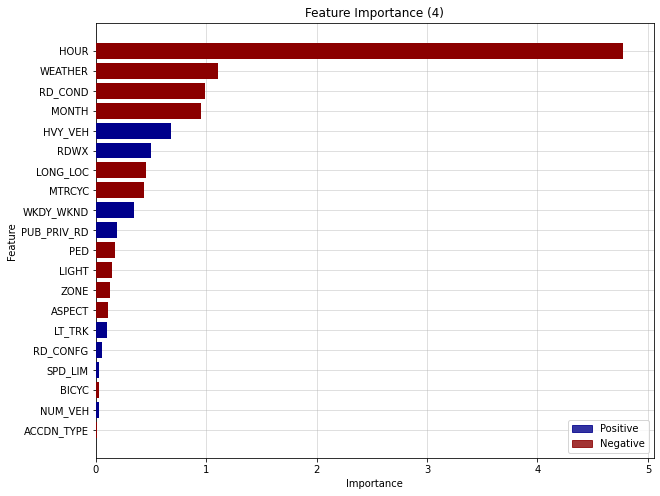

In [56]:
mtl_3sev_lr = model(data=data,    
                     folds=folds, 
                     impute_strategy=impute_strategy, 
                     classifier=classifier,
                     balance=balance,
                     filename_stem=filename_stem,
                     model_dir=model_dir,)

In [68]:
# Let's save the results so that we don't have to re-run the model to see them
# Convert the dataframes to dictionaries for storage in text file...

import copy

instance = mtl_3sev_lr

output = {'final': {} }
output['final']['evaluation'] = copy.deepcopy(instance.eval)
output['final']['feature_importance'] = instance.feature_importances

# Now we can use our save_gs_items function...

save_gs_items(model_dir=path["models"],
              filename='mtl_3sev_lr_final',
              gs_dict=output)  

In [69]:
# And we can load and display the results again here...

# And we can load and display the results again here...

filename = 'mtl_3sev_lr_final'
final_dict = load_gs_items(model_dir=model_dir, filename=filename)

beta = 2
weights = np.array([1,2,3])

metrics = { k : v for k, v in final_dict['final']["evaluation"].items() if k != "confusion"}
display(evaluation_df(metrics))
confusion_matrix_widget(final_dict['final']['evaluation'],
                        confusion_matrix_with_weighted_fbeta,
                        beta = beta,
                        weights = weights)
for i, cm in enumerate(final_dict['final']['evaluation']['confusion']):
    cm = confusion_matrix_with_weighted_fbeta(cm,
                        beta = beta,
                        weights = weights)

,ACC,BACC,precision,recall,F1,F2,MCC,ROC-AUC
0,0.734317,0.547604,0.457763,0.547604,0.476147,0.505577,0.327772,0.796377
1,0.734905,0.550570,0.460185,0.550570,0.479554,0.509569,0.330425,0.798321
2,0.734602,0.553484,0.458622,0.553484,0.477737,0.508531,0.327202,0.798365
3,0.734442,0.541047,0.456257,0.541047,0.473890,0.501885,0.327120,0.796115
4,0.734882,0.561932,0.462513,0.561932,0.483156,0.515738,0.331898,0.795654
mean,0.734630,0.550928,0.459068,0.550928,0.478097,0.508260,0.328883,0.796967



CONFUSION MATRIX: WEIGHTED ({0: 1, 1: 2, 2: 3}) AVERAGE CLASS-WISE F2 SCORE AT BOTTOM RIGHT



Dropdown(options=(0, 1, 2, 3, 4), value=0)

Output()

It is merely a matter of replacing the ```classifier``` attribute with ```RandomForestClassifier```,  ```DecisionTreeClassifier```, or ```GradientBoostingClassifier``` to try out these classifiers. Similarly, we can slice and dice the data in various ways, and try to predict other variables, by modifying the attributes of the ```process``` class.